## implementation of Wiener Filter based on PSNR and MSSIM for turbulence degradation

### importing necessary libraries

In [2]:
from skimage.metrics import structural_similarity
import math
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage.util import random_noise
from PIL import Image 
import PIL

### Reading Image

In [3]:
img = cv2.imread('aerial_view.tif',0)
img = cv2.resize(img,(525 , 525))

### Defining discrete fourier transform function

In [4]:
def dftuv(M, N) :   
    u =np.linspace(0, M-1,M)
    v =np.linspace(0, N-1,N)
    idx = np.where(u > M/2);
    u[idx] = u[idx] - M;
    idy = np.where(v > N/2);
    v[idy] = v[idy] - N;   
    V, U = np.meshgrid(v, u);
    return V,U

In [5]:
img = cv2.normalize(img, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_64F)
f = np.fft.fft2(img)

In [6]:
mag = np.abs(f)
ang = np.angle(f)
magnitude_spectrum = 20*np.log(np.abs(f))
m,n = magnitude_spectrum.shape 
v,u = dftuv(m, n)

### Defining turbulance function (degradation function)

In [7]:
k=0.0015
H_turb= np.exp(-k*(u**2 + v**2)**(5/6))
HF_turb =np.multiply(f, H_turb)
h_conv_f = np.real (np.fft.ifft2(HF_turb))

### Adding gaussian noise with zero mean and var=0.1

In [8]:
noise=np.zeros((525,525),dtype=np.float64)
noise=cv2.randn(noise,0,0.1)

noise_freq = np.fft.fft2(noise)
G_freq  =noise_freq + HF_turb

### Degraded Image (turbulance effect + noise)

In [9]:
noise_turb_space = np.real (np.fft.ifft2(G_freq))

### Initializing

In [10]:
k=np.linspace(0,1,100)
filtered_f = np.zeros((m,n,100)).astype(np.complex128)
filtered = np.zeros((m,n,100))
filtered_new = np.zeros((m,n,100))
score = np.zeros((100,))
psnr = np.zeros((100,))
k=np.linspace(0,0.6,100)

### Iterations for fining best k value

In [11]:
for i in range(0,100):
    
    filtered_f[:,:,i] = (G_freq / (H_turb) )* (np.abs(H_turb)**2)/((np.abs(H_turb)**2)+k[i])
    filtered[:,:,i] = np.real (np.fft.ifft2(filtered_f[:,:,i]))
    filtered = cv2.normalize(filtered, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_64F)
    (score[i], diff) = structural_similarity(img,filtered[:,:,i],data_range=img.max()-img.min(),full=True)
    psnr[i] = cv2.PSNR(img, filtered[:,:,i])   

### Best reported value for k based on PSNR and MSSIM

In [12]:
print ('K for max MSSIM = ', k[np.argmax(score)] ,'\nK for max PSNR = ', k[np.argmax(psnr)])

K for max MSSIM =  0.15757575757575756 
K for max PSNR =  0.06666666666666667


## Figures

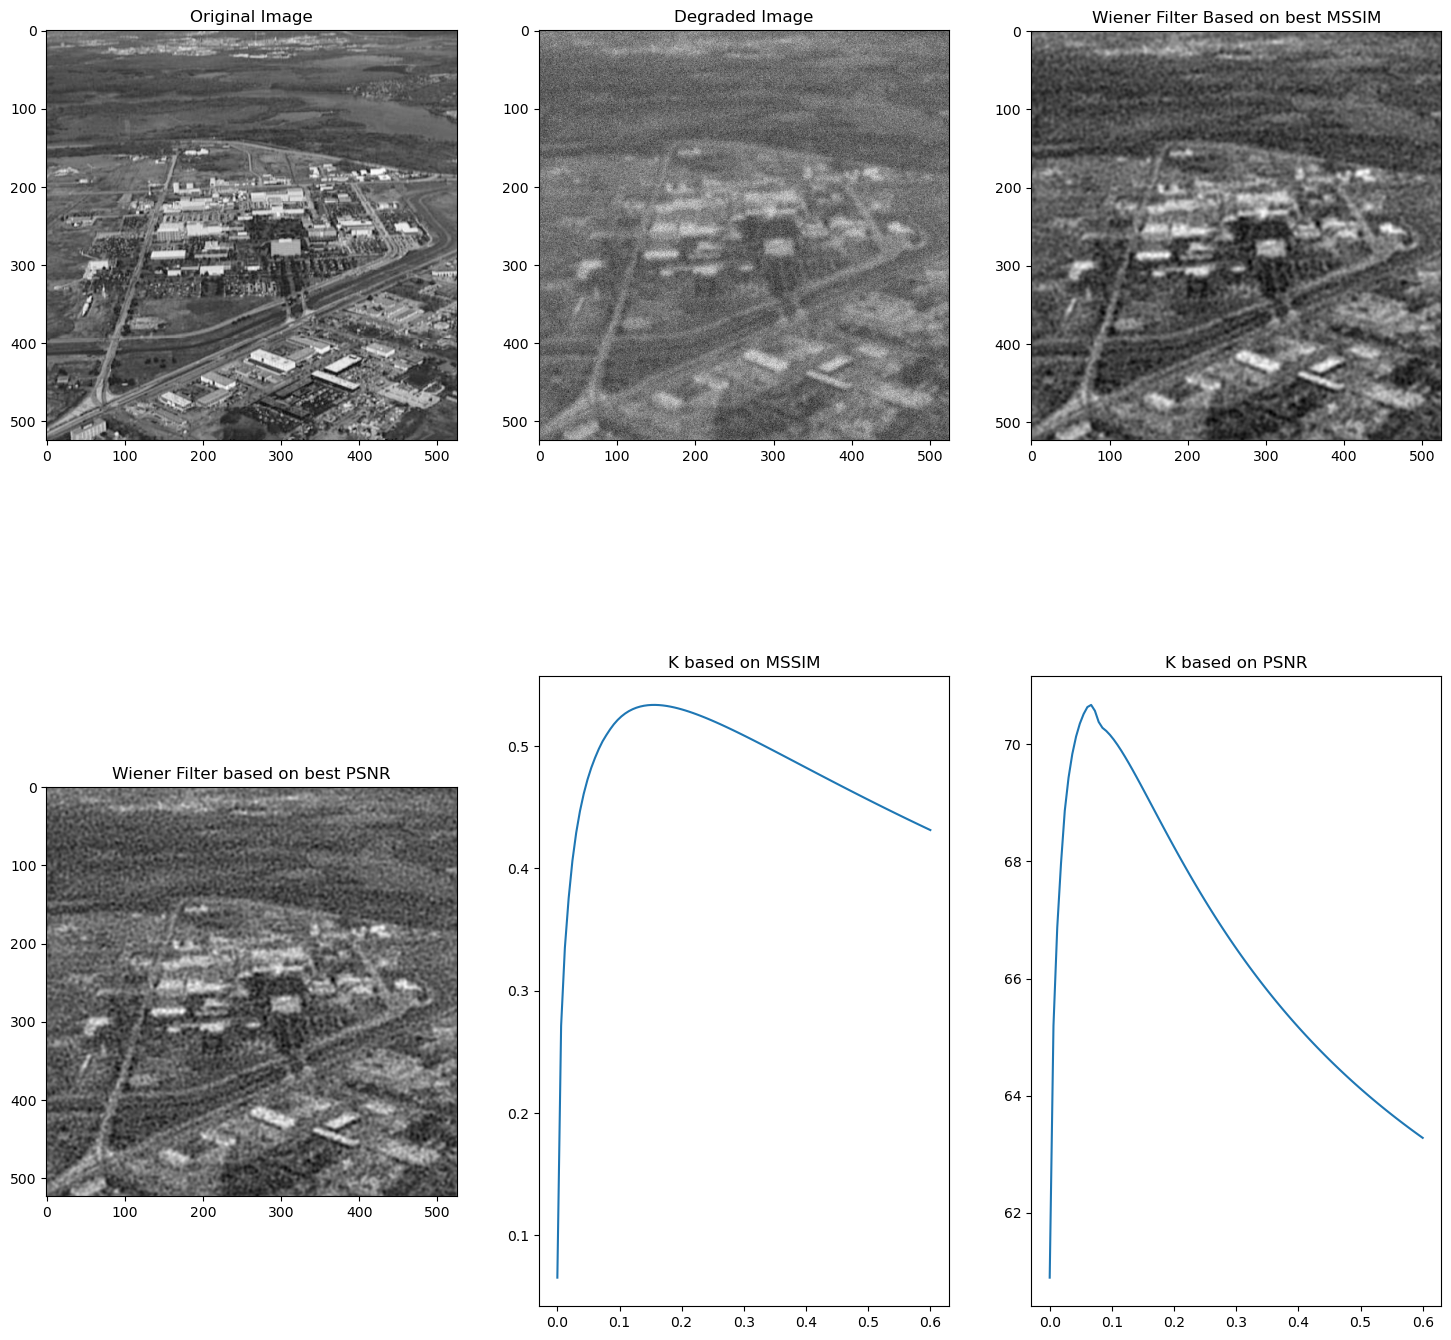

In [21]:
fig1 = plt.figure (figsize = (18,18))
ax1 = fig1.add_subplot (2,3,1)
ax1.imshow(img , cmap = 'gray')
ax1.title.set_text ('Original Image')

ax2 = fig1.add_subplot (2,3,2)
ax2.imshow (noise_turb_space , cmap = 'gray')
ax2.title.set_text ('Degraded Image')

ax3= fig1.add_subplot (2,3,3)
ax3.imshow (filtered[1:524,:,np.argmax(score)] , cmap='gray')
ax3.title.set_text('Wiener Filter Based on best MSSIM')

ax4= fig1.add_subplot (2,3,4)
ax4.imshow (filtered[1:524,:,np.argmax(psnr)] , cmap='gray')
ax4.title.set_text('Wiener Filter based on best PSNR')

ax5= fig1.add_subplot (2,3,5)
p1 = ax5.plot(k,score)
ax5.title.set_text('K based on MSSIM')

ax6= fig1.add_subplot (2,3,6)
p2 = ax6.plot(k,psnr)
ax6.title.set_text('K based on PSNR')